# A Walk-Through of a Simple zk-STARK Proof

This Python Notebook accompanies the article ``A Walk-Through of a Simple zk-STARK Proof'' by Berentsen, Lenzi and Nyffenegger (2022) and implements the numerical example.

The notebook is composed of three main parts in line with the article:
* **Definition of the problem** -- Define trace and constraints (agreement between prover and verifier)
* **Arithmetization** -- Representing the problem as an algebraic problem
* **Low degree testing** -- Check if the composition polynomial is of low degree 

In [47]:
#Import Packages
import numpy as np               #version: 1.21.5
import sympy                     #version: 1.10.1
from sympy import poly
from sympy.abc import x, y
import matplotlib.pyplot as plt  #version: 3.5.1
from merkle import MerkleTree, verify_decommitment  #The Merkle tree implementation is used from StarkWare Industries Ltd.

---------------------------------------------------------------------------------------------------------------------------------

# 1 Definition of the Problem

### 1.1 CI Statement, Trace and Polynomial Constraints

**Computational Integrity Statement:** “The prover has a sequence $A$ of $N$ integers, all of which are either 0 or 1 (boolean)”  
The statement is TRUE if all elements $A_i \in A$  are either 0 or 1.  
Example: $A^{true} = [1,0,1,1]$ is a true trace, $A^{false} = [2,0,1,1]$ is a false trace.

In [48]:
#Number of elements in the trace. Has to be power of 2 in our example. You can try 2**3,2**4,2**5 etc, but need to adjust M below.
N = 2**2

#Define the trace A, for replicability set seed to 5
np.random.seed(5)
A = list(np.random.randint(low = 0,high=2,size=N))

assert len(A)==N, "length of A is different from N"     # Check that A has length specified in N
assert (N & (N - 1)) == 0, "N not a power of 2" # Make sure that N is a power of 2
print('A = ', A, ' | The trace (A) is --> ', np.isin(A, [0, 1]).all())

A =  [1, 0, 1, 1]  | The trace (A) is -->  True


Prover and verifier agree on the constraints of the problem, i.e. $A_i^2-A_i=0 \quad \forall  i = 0,1,...,N-1$  

In [49]:
constraint = poly(y**2 - y)      # The only elements that are roots of these constraints are 0 and 1.

### 1.2 Finite Field

Next we define the finite field $F$ we work with. We choose a prime field and use the modulo operator with modulo $M=17$.  

In [50]:
M = 2**4+1                                              #Can alternatively choose 2**8+1, 2**16+1 etc
F = sympy.FiniteField(M)

def toInt(a):                                           #We define this function to be able to calculate integere values from the finite field expressions
    return int(sympy.FiniteField.to_sympy(0,a) % M)     #and to always get the positive integer realization and not the negative one.
assert sympy.isprime(M), f"M not a prime"               #Assert that M is a prime number
assert (M-1)%N == 0, f"N must be a divisor of (M-1)"    #N must be a divisor of (M-1) such that a subgroup exists
print('The Finite Field is:', F, '=', np.arange(0,M))

The Finite Field is: GF(17) = [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]


Furthermore, we calculate the multiplicative inverses $b = a^{-1}$ of the field elements $a\in F$ (where  $aa^{-1} = 1$) and store them for further use.  
We find them by calculating $a^{-1} = a^{M-2}$. (There is no multiplicative inverse for $0$ since division by $0$ is not possible).

In [51]:
F_inv = [0] * (M - 1)
for i in range(1,M):
    F_inv[i-1] = toInt(F(i)**(M-2))
              
print('The multiplicative inverses of F(M) are: ', F_inv)

The multiplicative inverses of F(M) are:  [1, 9, 6, 13, 7, 3, 5, 15, 2, 12, 14, 10, 4, 11, 8, 16]


---------------------------------------------------------------------------------------------------------------------------------

# 2 Arithmetization

### 2.1 Evaluating Trace as a Polynomial

**Find a generator of the subgroup $G$ (of the multiplicative group $\mathbb{F}_{/\{0\}}$) of size $N$**  
The idea of this code is to find by brute force the smallest integer $g$ in $\mathbb{F}_{/\{0\}}$ s.t. $\{g^0,g^1,g^2,...\}$ define a subgroup of size $N$. 

In [52]:
## Find generator g
G = [0] * M
g = 0
for i in range(1,M+1):
    G[0] = i
    for k in range(2,M+1):
        G[k-1] = G[k-2]*G[0] % M
    if len(np.unique(G)) == N:
        g = i
        break       
assert g!=0, "No generator g found"
print('The generator g of the subgroup is -->', g)

## Define subgroup G
G[0] = 1
G[1] = g
for i in range(2,M):
    G[i-1] = G[i-2]*g % M
G = np.unique(G) 
print('The subgroup G is -->', G)

The generator g of the subgroup is --> 4
The subgroup G is --> [ 1  4 13 16]


**Interpolate Polynomial f**  
The prover calculates the **lowest degree polynomial** which has the property $f(g^i) = A_i$ , $\quad$  $\forall i=0,..,N-1$  
The code interpolates the points in $G$.

In [53]:
#Lagrange Interpolation
l1 = [0] * N
f = poly(0,x,domain=F)
for i in range(0,N):
    l1[i] = 1
    for j in range(0,N):
        if j != i:
            l1[i] = l1[i] * (x - G[j]) * F_inv[(G[i] - G[j] - 1) % M]
    f = f + A[i] * l1[i]  
f = poly(f, domain = F)
print(' ')
print('The polynomial f associated to the trace ', A, ' is: ', f)

 
The polynomial f associated to the trace  [1, 0, 1, 1]  is:  Poly(-x**3 - 4*x**2 + x + 5, x, modulus=17)


### 2.2 Evaluate the Polynomial on a Larger Domain

We now want to evaluate the polynomial on a larger domain $L$, where $L = F_{/\{0\}}$.  

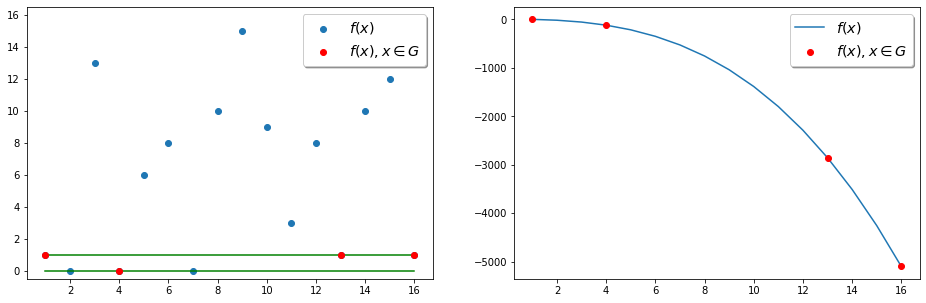

In [54]:
#Define domain L where polynomial is evaluated
L = np.array(range(1,M))

#Calculate f(x) for x in L
f_yy = [0] * len(L)
for i in range(0,len(L)):
    f_yy[i] = toInt(f(i+1))

#Calculate f(x) only for x in G to color dots red
f_G = [0] * N
for i in range(0,N):
    f_G[i] = toInt(f(G[i])) 
    
#Calculate f(x) in Euclidean space
coeffs = f.all_coeffs()[::-1]
yy = np.array([np.sum(np.array([coeffs[i]*(j**i) for i in range(len(coeffs))])) for j in L])
yy1 = np.array([np.sum(np.array([coeffs[i]*(j**i) for i in range(len(coeffs))])) for j in G]) #caluclate f(x) only for G

#Plot Graph
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(16, 5)
ax1.scatter(L, f_yy, zorder = 1, label = r'$f(x)$')
ax1.scatter(G,f_G, color = 'red', zorder = 2, label = r'$f(x), x \in G$')
ax1.plot(L,[0]*L, color = 'green', zorder = 1)
ax1.plot(L,[0]*L + 1, color = 'green', zorder = 1)
ax1.set_ylim([-0.5, M-0.5])
ax1.legend(loc='best', shadow=True, fontsize='x-large')
ax2.plot(L, yy, zorder = 1, label = r'$f(x)$')
ax2.scatter(G,yy1, color = 'red', zorder = 2, label = r'$f(x), x \in G$')
ax2.legend(loc='best', shadow=True, fontsize='x-large')
plt.show()

### 2.3 Apply Constraints to Polynomial

We now combine the constraint defined above with the polynomial $f$ to get $c(x) = f(x)^2 -f(x)$

In [55]:
#Get constraint polynomial
c = sympy.compose(constraint,f)
c = poly(c,x,domain = F)
print('We have c(x) = ', c)

We have c(x) =  Poly(x**6 + 8*x**5 - 3*x**4 - x**2 - 8*x + 3, x, modulus=17)


Plot the constraint polynomial $c(x)$:

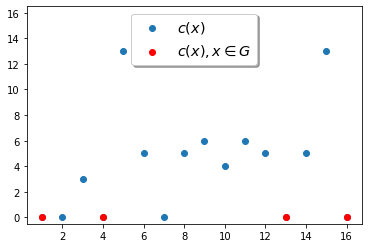

In [56]:
#Calculate c(x) for x in L
c_yy = [0] * len(L)
for i in range(0,len(L)):
    c_yy[i] = toInt(c(i+1))

##Calculate c(x) only for x in G
c_G = [0] * N
for i in range(0,N):
    c_G[i] = toInt(c(G[i]))

##Plot graph
plt.scatter(L, c_yy, zorder = 1, label = r'$c(x)$')
plt.scatter(G,c_G, color = 'red', zorder = 2, label = r'$c(x), x \in G$')
plt.ylim([-0.5, M-0.5])
plt.legend(loc=9, shadow=True, fontsize='x-large')
plt.show()

### 2.4 Create the Composition Polynomial

We now define the Composition Polynomial, i.e.  $p(x) = \dfrac{c(x)}{x^N-1}$

In [57]:
#First calcualte the denominator
u = poly(x**N - 1, domain = F)   

#Calculate the composition polynomial
pRaw = sympy.div(c, u, domain = F)
p = pRaw[0]; pRemainder = pRaw[1]
print('Composition polynomial: ', p, ' , The remainder is: ', pRemainder); print(' ')

Composition polynomial:  Poly(x**2 + 8*x - 3, x, modulus=17)  , The remainder is:  Poly(0, x, modulus=17)
 


Plot the composition polynomial $p(x)$:

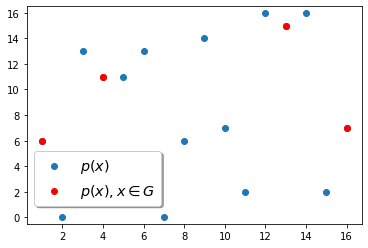

In [58]:
#Calculate p(x) for x in L
p_yy = [0] * len(L)
for i in range(0,len(L)):
    p_yy[i] = toInt(p(i+1))

##Calculate p(x) only for x in G
p_G = [0] * N
for i in range(0,N):
    p_G[i] = toInt(p(G[i]))

##Plot graph
plt.scatter(L, p_yy, zorder = 1, label = r'$p(x)$')
plt.scatter(G,p_G, color = 'red', zorder = 2, label = r'$p(x), x \in G$')
plt.ylim([-0.5, M-0.5])
plt.legend(loc='lower left', bbox_to_anchor=(0, 0.05), shadow=True, fontsize='x-large')
plt.show()

### 2.5 Commitments

The prover now commits to $f(x)$ and $p(x)$ in Merkle trees. We use the Merkle tree script from Starkware.

In [59]:
#Build Merkle tree
MT_f = MerkleTree(f_yy)
MT_p = MerkleTree(p_yy)    

#Get Merkle roots
root_f = MT_f.root
root_p = MT_p.root

print('Prover sends Merkle root of MT_f to verifier: ')
print(root_f)
print('The leaves of MT_f are: ', MT_f.data); print(' ')
print('Prover sends Merkle root of MT_p to verifier: ')
print(root_p)
print('The leaves of MT_p are: ', MT_p.data)

Prover sends Merkle root of MT_f to verifier: 
3ffb41e31ea9f86466a4871ac55d4ee78dde430fbed741b8cceb3f43321cf96e
The leaves of MT_f are:  [1, 0, 13, 0, 6, 8, 0, 10, 15, 9, 3, 8, 1, 10, 12, 1]
 
Prover sends Merkle root of MT_p to verifier: 
2e9b0882df3c19559754ea9cae76babc40fbc7950f79326046ac8479f066717e
The leaves of MT_p are:  [6, 0, 13, 11, 11, 13, 0, 6, 14, 7, 2, 16, 15, 16, 2, 7]


### 2.6. Querying

Motivation of why we want to query the equation $p(x)u(x) = c(x)$.

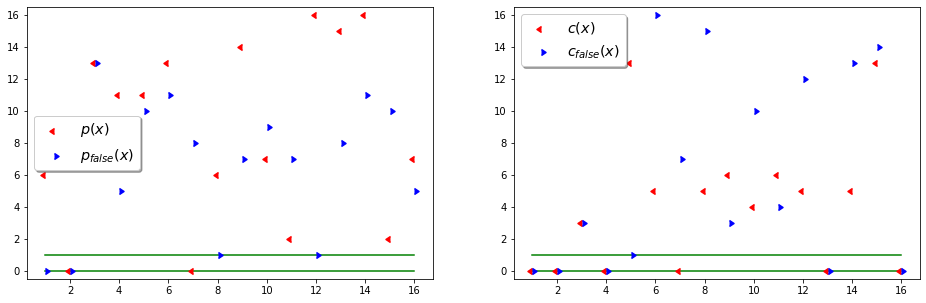

In [60]:
#Define p_false
p_false = poly(15*x**2+6*x+13, domain = F)
c_false = p_false*u

#Calculate y values
p_false_yy = [0] * len(L)
c_false_yy = [0] * len(L)
for i in range(0,len(L)):
    p_false_yy[i] = toInt(p_false(i+1))
    c_false_yy[i] = toInt(c_false(i+1))

#Plot Graph
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(16, 5)
ax1.scatter(L, p_yy, marker = 8, color = 'red', zorder = 2, label = '$p(x)$')
ax1.scatter(L, p_false_yy, marker = 9 ,color = 'blue', zorder = 2, label = '$p_{false}(x)$')
ax1.plot(L,[0]*L, color = 'green', zorder = 1)
ax1.plot(L,[0]*L + 1, color = 'green', zorder = 1)
ax1.set_ylim([-0.5, M-0.5])
ax1.legend(loc='center left', shadow=True, fontsize='x-large')
ax2.scatter(L, c_yy, marker = 8, color = 'red', zorder = 2, label = '$c(x)$')
ax2.scatter(L, c_false_yy, marker = 9 ,color = 'blue', zorder = 2, label = '$c_{false}(x)$')
ax2.plot(L,[0]*L, color = 'green', zorder = 1)
ax2.plot(L,[0]*L + 1, color = 'green', zorder = 1)
ax2.set_ylim([-0.5, M-0.5])
ax2.legend(loc='best', shadow=True, fontsize='x-large')
plt.show()


**Querying Protocol**  
The verifier queries the prover for values $\{z\in L | z\notin G \}$.  
The prover returns $f(z)$, $p(z)$ and the Merkle paths corresponding to $z$.  
The verifier checks whether (i) the received values fit the commitment and (ii) the equation  
$p(z) = \dfrac{f(z)^2-f(z)}{z^N-1}$  
holds.

In [61]:
#Choose number of queries q
q = 1

#Get random numbers, set seed to 70 for replicabiltiy
assert q <= len(L)-N, "You query more often than possible, reduce q"
np.random.seed(70) 
z = list(np.random.choice(np.delete(L,G-1,0), q, replace=False)) #Exclude G values from possible queries

print('The selected random numbers are: ', z); print(' ')

#Querying rounds
for i in range(0,len(z)):
    print('-----------------')
    print('Query ', i+1,': ')
    print('Verifier queries: z=',z[i]); print(' ')
    
    #Prover sends information
    print(f'Prover sends: f({z[i]}) = {toInt(f(z[i]))} and p({z[i]}) = {toInt(p(z[i]))},')
    print('the correpsonding Merkle Paths for f(z):')
    leafID = np.where(L==z[i])[0][0] 
    path_f = MT_f.get_authentication_path(leafID)
    print(path_f)
    print('and for p(z):')
    path_p = MT_p.get_authentication_path(leafID)
    print(path_p)
    print(' ')
    
    #Calculate equation 
    print('(i): Verifier now checks equation: p(z)(z^N-1) = f(z)^2-f(z)')
    LHS = toInt(toInt(p(z[i]))*(toInt(z[i])**N-1))
    RHS = toInt(((toInt(f(z[i]))*toInt(f(z[i])))- toInt(f(z[i]))))
    print('LHS yields: ', LHS, '; RHS yields: ', RHS)
    if LHS==RHS:
        print(f'Equation correct, proof continues')
    else:
        print(f'PROOF FAILS: Equation not correct.'); break
    print(' ')
    
    #Check if Merkle root fits the one received before
    print('(ii): Verifier now checks whether received p(z) and f(z) correspond to Merkle root received upfront')
    if verify_decommitment(leafID, toInt(f(z[i])), path_f, root_f): #check for f
        print('f(z) corresponds to commitment, proof can continue')
    else:
        print('PROOF FAILS: f(z) DOES NOT corresponds to commitment!'); break
    if verify_decommitment(leafID, toInt(p(z[i])), path_p, root_p): #check for p
        print('p(z) corresponds to commitment, proof can continue')
    else:
        print('PROOF FAILS: p(z) DOES NOT corresponds to commitment!'); break

The selected random numbers are:  [3]
 
-----------------
Query  1 : 
Verifier queries: z= 3
 
Prover sends: f(3) = 13 and p(3) = 13,
the correpsonding Merkle Paths for f(z):
['f80db67243d8d42460288db28cfa0e22b54935c6a7bdf377ff53194437238644', 'da7246388ff10833dcec4fb82f9d70772a7acf688ea9899be279c43ec0be17c6', 'dbdbf4fb684471f421fb255100e433c77fd1aac71c7a3739e9897168aec67ec1', '5feceb66ffc86f38d952786c6d696c79c2dbc239dd4e91b46729d73a27fb57e9']
and for p(z):
['b2112f1d77950726943365ed742a696582a8c689f5693369c65c785940d54cf2', '51847fcdbd6726ff748a6c7845717b431b9e1b2e9e4a0e8475dee27aebf60c86', 'ce59e1db179747f39b86e895ef8f9a2d647746569b19164677cf1babddaf4c39', '4fc82b26aecb47d2868c4efbe3581732a3e7cbcc6c2efb32062c08170a05eeb8']
 
(i): Verifier now checks equation: p(z)(z^N-1) = f(z)^2-f(z)
LHS yields:  3 ; RHS yields:  3
Equation correct, proof continues
 
(ii): Verifier now checks whether received p(z) and f(z) correspond to Merkle root received upfront
f(z) corresponds to commitment, pr

---------------------------------------------------------------------------------------------------------------------------------

# 3 Low-Degree Testing

The objective of the low-degree testing is that the verifier can learn whether the composition polynomial is of low degree by just a few querying steps.

### 3.1 Motivation

Here we calcluate another polynomial $f^{H}$ of high degree that fits $f$ in all points $x \in L$ except for one $x$ where $x\in G$. (Specifically we set $f^H(16)=4$)  
This shows that it is possible with a high degree polynomial to be sufficiently close to a low degree polynomial such that the tests that we did so far are not sufficient to trust the prover. 

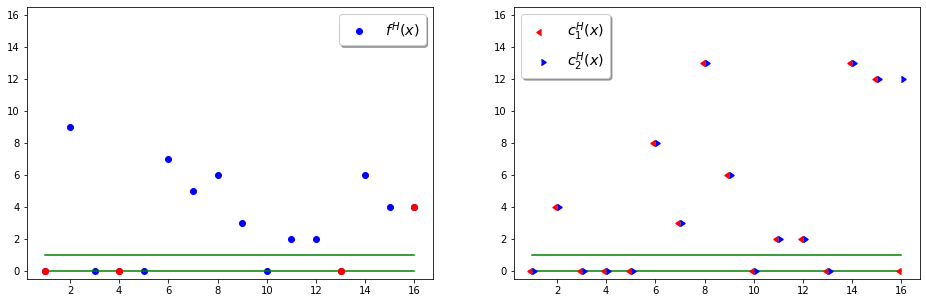

In [62]:
#Define polys
f_H = poly(x**15 + 4*x**14 + 6*x**13 +  11*x**12 + 6*x**11 + 5*x**10 + 6*x**9 + 13*x**8 + 7*x**7 + 7*x**6 + 12*x**5 + 8*x**4 + 2*x**3 + 2*x**2 + 9*x + 3, x, modulus=17)
p_H  = poly(13*x**15 + 8*x**14 + 11*x**13 + 2*x**12 + 16*x**11 + 9*x**10 + 3*x**9 + 11*x**8 + 6*x**7 + 14*x**6 + 13*x**5 + 4*x**4 + 8*x**3 + 3*x**2 + 2*x + 14, x, modulus=17)

#Define vector for u
u_vec = [0]*L
for i in range(len(L)):
    u_vec[i] = ((i+1)**4-1)%M
u_vec[i] = np.array(u_vec[i])

#Calculate y points of polys
f_H_yy = [0] * len(L)
p_H_yy = [0] * len(L)
for i in range(0,len(L)):
    f_H_yy[i] = toInt(f_H(i+1))
    p_H_yy[i] = toInt(p_H(i+1))

#Calculate c1 and c2
c1_H_yy = [0]*len(L)
c2_H_yy = [0]*len(L)
for k in range(len(L)):
    c1_H_yy[k] = (p_H_yy[k]*u_vec[k])%M         
    c2_H_yy[k] = ((f_H_yy[k])**2-f_H_yy[k])%M  

##Calculate f(x) only for x in G
f_H_G = [0] * N
for i in range(0,N):
    f_H_G[i] = toInt(f_H(G[i]))

#Plot Graph
fig, (ax1,ax2) = plt.subplots(1,2)
fig.set_size_inches(16, 5)
ax1.scatter(L, f_H_yy, color = 'blue', zorder = 1, label = '$f^H(x)$')
ax1.scatter(G, f_H_G, color = 'red', zorder = 2)
ax1.plot(L,[0]*L, color = 'green', zorder = 1)
ax1.plot(L,[0]*L + 1, color = 'green', zorder = 1)
ax1.set_ylim([-0.5, M-0.5])
ax1.legend(loc='best', shadow=True, fontsize='x-large')
ax2.scatter(L, c1_H_yy, marker = 8, color = 'red', zorder = 2, label = '$c_1^H(x)$')
ax2.scatter(L, c2_H_yy, marker = 9 ,color = 'blue', zorder = 2, label = '$c_2^H(x)$')
ax2.plot(L,[0]*L, color = 'green', zorder = 1)
ax2.plot(L,[0]*L + 1, color = 'green', zorder = 1)
ax2.set_ylim([-0.5, M-0.5])
ax2.legend(loc='best', shadow=True, fontsize='x-large')
plt.show()

### 3.2 Setup

We now define $\bar{d}$, i.e. the highest possible degree for the composition polynomial.  
In our example this is defined by: $\bar{d} = 2(N-1)-N = N-2$.

In [63]:
d_bar = N - 2
print('The highest possible degree of the composition polynomial is:',d_bar)

The highest possible degree of the composition polynomial is: 2


### 3.3 Commitment Round

In the commitment round, the prover executes the FRI protocol.  
We know that after applying the FRI operator exactly $\lambda = \log_2(\bar{d})+1$ times, the polynomial is reduced to a constant.  
In each round, the verifier sends a random $\alpha\in F$ which the prover needs.  
The prover commits in each round to the current state and at the end sends the remaining constant to the verifier.

In [64]:
#Calculate number of iterations in the FRI protocol
Lambda = int(np.log2(d_bar) + 1)
print('The FRI protocol will take', Lambda, 'iterations.')

The FRI protocol will take 2 iterations.


First we predefine some variables and define a function that returns the domain depending on the size of $L$ and which iteration we are in.

In [65]:
#Set a vector to store p_k, ie the polynomials
P = [0]*(Lambda+1) 
P[0] = p

#Set alpha, for replicability set seed to 260  
np.random.seed(260)
alpha = list(np.random.randint(low = 0,high=M,size=Lambda)) #do it random
assert len(alpha) == Lambda, "Not enough elements for alpha"
print('Alphas sent to the prover are: ',alpha)

#Set up vectors to store Merkle tree commitments
merkleTrees = [0]*(Lambda-1)
merkleRoots = [0]*(Lambda-1)

#Define function to get domain
def getDomain(L,k):
    assert (len(L) & (len(L) - 1)) == 0, "Size of L is not a power of 2" #assert size of L is a power of 2
    for _ in range(k+1):
        L = np.unique(L**2%M)
    return L

Alphas sent to the prover are:  [10, 15]


And then the prover performs the FRI protocol.

In [66]:
#Apply the FRI operator Lambda times
for k in range(0,Lambda):
    #Prover splits p_k into even and odd parts
    g = sympy.Poly.from_list(P[k].all_coeffs()[::-1][::2][::-1], x, domain = F)       # Prover separates into even part
    h = sympy.Poly.from_list(P[k].all_coeffs()[::-1][1::2][::-1], x, domain = F)      # Prover separates into odd part

    #Calculate next p_k polynomial
    P[k+1] = g + poly(alpha[k],x,domain=F) * h
    
    if k == Lambda-1:
        constant = int(P[k+1](0))
        print('------------')
        print('Round ', k+1, ' of ', Lambda)
        print('A constant remains: ',toInt(constant))
    else:
        #####Commit this polynomial over L^2, L^4 etc...
        #First get domain
        Lcur = getDomain(L,k)
        
        #Calculate p_k(x) values in this domain for leaves of the Merkle tree
        leaves = [0] * len(Lcur)
        for i in range(0,len(Lcur)):
            leaves[i] = toInt(P[k+1](Lcur[i]))
        merkleTrees[k] = MerkleTree(leaves)
        merkleRoots[k] = merkleTrees[k].root
        print('------------')
        print('Round ', k+1, ' of ', Lambda)
        print('The new polynomial is:', P[k+1])
        print('The polynomial is evaluated in:' , Lcur)
        print('The leaves of the Merkle tree are: ', leaves)
            
#Send constant
print(' ')
print('The prover now sends the constant:', toInt(constant))
print('and the Merkle roots to the verifier:')
print(merkleRoots)

------------
Round  1  of  2
The new polynomial is: Poly(x - 8, x, modulus=17)
The polynomial is evaluated in: [ 1  2  4  8  9 13 15 16]
The leaves of the Merkle tree are:  [10, 11, 13, 0, 1, 5, 7, 8]
------------
Round  2  of  2
A constant remains:  7
 
The prover now sends the constant: 7
and the Merkle roots to the verifier:
['f96d0041ca65368249c38a7a279287aefe13f3bc514eb9f4be7ffc59c4a893c7']


### 3.4 Querying Round

The verifier ''replicates'' the FRI protocol and checks whether after $\lambda$ steps he ends up with the constant received before and whether in each round his calculation fits the commitment.  
The verifier queries for $\{z \in L|z\notin G\}$. We first define which $z$ the verifier chooses.

In [67]:
#Define the z that the verifier queries for, for replicability set seed to 2
np.random.seed(2) 
z = np.random.choice(np.delete(L,G-1,0), 1, replace=False)[0] #Exclude G values from possible queries
print('The verifier queries for z =',z)

The verifier queries for z = 12


The verifier now ''repliactes'' the protocol. He iterates exactly $\lambda$ times. After doing so he should end up with the constant received before. On the way he checks the commitment by querying the prover for the Merkle paths and checking the Merkle roots.  
Note that the verifier would query for several $z$. So he would just choose another $z$ and repeats the exact same steps.

In [68]:
for k in range(0,Lambda):
    print(' ')
    print('Round ', k+1, ' of ', Lambda)
    print('----------------')
    
    #verifier queries for p(z^2^k) and p(-z^2^k)
    pP = toInt(P[k](toInt(F(z)**(2**k))))
    pN = toInt(P[k](toInt(F(-1)*F(z)**(2**k))))
    print(f'The prover returns p({z}^{2**k})={pP} and p(-{z}^{2**k})={pN}')
    
    #Verifier solves system of equations to get g(z^2^k) and h(z^2^k)
    h_ver = toInt(F((pP-pN)*F_inv[toInt(F(2)*F(z)**(2**k))-1]))
    g_ver = toInt(F(pN) + F(z)**(2**k)*F(h_ver))
    print(f'The verifier finds g(z^{2**(k+1)})={g_ver} and h(z^{2**(k+1)})={h_ver}')
    
    #Compute next p_{k+1}(z)
    pZ_ver = toInt(F(g_ver) + F(alpha[k])*F(h_ver))
    print(f'and then calculates p_{k+1} = g(z^{2**(k+1)}) + alpha_{k+1} h(z^{2**(k+1)})', 
          f'= {g_ver}+{alpha[k]}*{h_ver} = {pZ_ver}')
    
    #Check commitment, do not need to check commitment in last round, just compare constants in last round
    if k<Lambda-1: 
        print(' ')
        print(f'Verifier checks whether calculated p_{k+1}={pZ_ver} correspond to commitment in Merkle tree')
        leafID = np.where(getDomain(L,k)==toInt(F(z)**(2**(k+1))))[0][0] 
        path = merkleTrees[k].get_authentication_path(leafID)
        print(f'Prover sends authentification path for leaf number {leafID}, where z={toInt(F(z)**(2**(k+1)))}',
              f'and p_{k+1}({toInt(F(z)**(2**(k+1)))})={toInt(P[k+1](toInt(F(z)**(2**(k+1)))))} this is:')
        print(' '); print(path)
        print('and uses this to calculate the Merkle Root'); print(' ')
        
        if verify_decommitment(leafID, pZ_ver, path, merkleRoots[k]): 
            print(f'p_{k+1}={pZ_ver} corresponds to commitment, proof can continue.')
        else:
            print(f'PROOF FAILS, p_{k+1}={toInt(pZ_ver)} DOES NOT correspond to commitment!')
    else:
        print(f'Verifier finds constant {toInt(pZ_ver)} which equals {toInt(constant)} received from prover')
        print('PROOF SUCCESSFUL!')

 
Round  1  of  2
----------------
The prover returns p(12^1)=16 and p(-12^1)=11
The verifier finds g(z^2)=5 and h(z^2)=8
and then calculates p_1 = g(z^2) + alpha_1 h(z^2) = 5+10*8 = 0
 
Verifier checks whether calculated p_1=0 correspond to commitment in Merkle tree
Prover sends authentification path for leaf number 3, where z=8 and p_1(8)=0 this is:
 
['6588d7c2b4ef0eb0fad71bef665465390357fb053f58f24302008a5e723ba4bc', '1f12220da624f190b8e2d897ff9400503d1ada72cc2569499001ebf96485c80a', '3fdba35f04dc8c462986c992bcf875546257113072a909c162f7e470e581e278']
and uses this to calculate the Merkle Root
 
p_1=0 corresponds to commitment, proof can continue.
 
Round  2  of  2
----------------
The prover returns p(12^2)=0 and p(-12^2)=1
The verifier finds g(z^4)=9 and h(z^4)=1
and then calculates p_2 = g(z^4) + alpha_2 h(z^4) = 9+15*1 = 7
Verifier finds constant 7 which equals 7 received from prover
PROOF SUCCESSFUL!


-------------------------------------------------------------------------------------------------------------------------

## 4 Attack With False Trace

This part only works for the values in the numerical example, ie $M=17$ and $N=4$.

The polynomial f_false asociated to the trace  [2 0 1 1]  is:  Poly(-5*x**3 - 8*x**2 - 3*x + 1, x, modulus=17)
c polynomial:  Poly(8*x**6 - 5*x**5 - 8*x**4 - 8*x**3 + x**2 - 3*x, x, modulus=17)
Composition polynomial:  Poly(8*x**2 - 5*x - 8, x, modulus=17)  , The remainder is:  Poly(-8*x**3 - 8*x**2 - 8*x - 8, x, modulus=17)
c_bar polynomial:  Poly(8*x**6 - 5*x**5 - 8*x**4 - 8*x**2 + 5*x + 8, x, modulus=17)


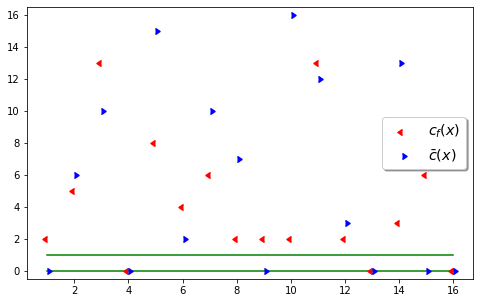

In [69]:
if M==17 and N==4:
    #Define the trace that the poly f_false needs to fit
    A_false = np.array([2,0,1,1])

    #Interpolate values
    l1 = [0] * N
    f_false = poly(0,x,domain=F)
    for i in range(0,N):
        l1[i] = 1
        for j in range(0,N):
            if j != i:
                l1[i] = l1[i] * (x - G[j]) * F_inv[(G[i] - G[j] - 1) % M]
        f_false = f_false + A_false[i] * l1[i]  
    f_false = poly(f_false, domain = F)
    print('The polynomial f_false asociated to the trace ', A_false, ' is: ', f_false)

    #Calculate c
    c_false = sympy.compose(constraint,f_false)
    c_false = poly(c_false,x,domain = F)
    print('c polynomial: ', c_false)

    #Calculate composition polynomial
    pRaw_false = sympy.div(c_false, u, domain = F)
    p_false = pRaw_false[0]; pRemainder_false = pRaw_false[1]
    print('Composition polynomial: ', p_false, ' , The remainder is: ', pRemainder_false)

    #Calculate c_bar(x)
    c_bar = p_false*u
    print('c_bar polynomial: ', c_bar)

    #Calculate c_f(x) and c_bar(x) for x in L
    c_bar_yy = [0] * len(L)
    c_false_yy = [0] * len(L)
    for i in range(0,len(L)):
        c_bar_yy[i] = toInt(c_bar(i+1))
        c_false_yy[i] = toInt(c_false(i+1))

    #Plot Graph
    fig, (ax1) = plt.subplots(1, 1)
    fig.set_size_inches(8, 5)
    ax1.scatter(L, c_false_yy, marker = 8, color = 'red', zorder = 2, label = '$c_f(x)$')
    ax1.scatter(L, c_bar_yy, marker = 9 ,color = 'blue', zorder = 2, label = r'$\bar{c}(x)$')
    ax1.plot(L,[0]*L, color = 'green', zorder = 1)
    ax1.plot(L,[0]*L + 1, color = 'green', zorder = 1)
    ax1.set_ylim([-0.5, M-0.5])
    ax1.legend(loc='best', shadow=True, fontsize='x-large')
    plt.show()